In [ ]:
pip install keras

In [ ]:
import numpy as np
import os
from matplotlib.image import imread
import tensorflow as tf
import random
from tensorflow.keras.layers import Input, Flatten, Dense,Reshape, Activation, LeakyReLU, MaxPooling2D, UpSampling2D, InputLayer
from keras import Sequential
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, BaseLogger
import matplotlib.pyplot as plt
from keras.losses import mse, binary_crossentropy
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import cv2
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tensorflow.keras.preprocessing import image

In [ ]:
#must put the notebook setting on GPU first
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import sys 
from google.colab import drive 
import glob

path = "/content/drive" 
drive.mount(path, force_remount=True)  
data_path = "drive/MyDrive/Challenge(1)/dataset"
training_data_path = "drive/MyDrive/Challenge(1)/dataset/training" 

myfiles = glob.glob(os.path.join(data_path, '*')) 
print(myfiles)

Mounted at /content/drive
['drive/MyDrive/Challenge(1)/dataset/stl10.zip', 'drive/MyDrive/Challenge(1)/dataset/validation', 'drive/MyDrive/Challenge(1)/dataset/training', 'drive/MyDrive/Challenge(1)/dataset/\\second_output.csv', 'drive/MyDrive/Challenge(1)/dataset/stl10.zip (Unzipped Files)', 'drive/MyDrive/Challenge(1)/dataset/siamese_checkpoints', 'drive/MyDrive/Challenge(1)/dataset/variables', 'drive/MyDrive/Challenge(1)/dataset/assets', 'drive/MyDrive/Challenge(1)/dataset/saved_model.pb', 'drive/MyDrive/Challenge(1)/dataset/keras_metadata.pb', 'drive/MyDrive/Challenge(1)/dataset/conv_checkpoints', 'drive/MyDrive/Challenge(1)/dataset/encoder_weights.h5', 'drive/MyDrive/Challenge(1)/dataset/decoder_weights.h5', 'drive/MyDrive/Challenge(1)/dataset/new_dataset_pokemon_animals_clothes', 'drive/MyDrive/Challenge(1)/dataset/conv1_checkpoints', 'drive/MyDrive/Challenge(1)/dataset/test']


Importing our training data 

In [ ]:
class Dataset(object):
    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path), 'Insert a valid path!'

        # get class list
        self.data_classes = os.listdir(self.data_path)

        # init mapping dict
        self.data_mapping = {}

        # populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            temp_images = os.listdir(temp_path)

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)

                if img_tmp.endswith('.jpg'):
                    if c_name == 'distractor':
                        self.data_mapping[img_tmp] = -1
                    else:
                      if c_name.isnumeric():
                        self.data_mapping[img_tmp] = int(c_name)
                      else :
                        self.data_mapping[img_tmp] = c_name

        print('Loaded {:d} from {:s} images'.format(len(self.data_mapping.keys()),
                                                    self.data_path))

    def get_data_paths(self):
        # returns a list of imgpaths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.endswith('.jpg'):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)


    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)

  


    


#validation_path = os.path.join(data_path, 'validation')
#test_path= os.path.join(validation_path, "test")
#gallery_path = os.path.join(validation_path, 'gallery')
#query_path = os.path.join(validation_path, 'query')
training_path = os.path.join(data_path, "training") 
training_path = training_data_path
#print(training_path)
training_dataset = Dataset(data_path = training_path)
#gallery_dataset = Dataset(data_path=gallery_path)
#query_dataset = Dataset(data_path=query_path)
#test_dataset = Dataset(data_path = test_path)

# get training data and classes
training_paths, training_classes = training_dataset.get_data_paths()
#test_paths, test_classes = test_dataset.get_data_paths()
# we get validation gallery and query data
#gallery_paths, gallery_classes = gallery_dataset.get_data_paths()
#query_paths, query_classes = query_dataset.get_data_paths()

Loaded 2233 from drive/MyDrive/Challenge(1)/dataset/training images


Converting the dataset to an array of normalized values

In [ ]:
def convert_to_array(file_array):
  """
  Reading and Converting images into numpy array by taking path of images.
  Arguments:
  file_array - (list) - list of file(path) names
  Returns:
  A numpy array of images.
  """


  list_of_pics_array= []
  for img in tqdm(file_array):
    original = load_img(img, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image = np.expand_dims(numpy_image, axis=0)
    image /=255
    list_of_pics_array.append(image)
    
  images = np.vstack(list_of_pics_array)

 
  return images

 

training_dataset = convert_to_array(training_paths)
#print("Length of training dataset:",training_dataset.shape)
#query_dataset = convert_to_array(query_paths)
#test_dataset = convert_to_array(test_paths)
#print("Length of test dataset:",query_dataset.shape)
#gallery_dataset = convert_to_array(gallery_paths)

100%|██████████| 2233/2233 [00:09<00:00, 241.55it/s]


Randomly shuffling the dataset to avoid the model to recognize the first/last pictures at every training 

In [ ]:

#adding some randomness - some additional noisy images will have to be added
training_dataset = tf.random.shuffle(
    training_dataset, seed=466, name=None
)


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
checkpoint_path = "drive/MyDrive/Challenge(1)/dataset/conv1_checkpoints"

Defining the autoencoder model, having an input shape, output shape, filt certain filters, and further parameters used to enhance training such as stdev, stride and padding (for deciding the shifting of the kernel over the input array). 

In [ ]:
class ConvAutoEncoder():
  """
  
  """

  def __init__(self, input_shape, output_dim, filters, optimizer,
               kernel=(3,3), stride=(2,2), strideundo=2, pool=(2,2), stdev = 0.3,
               lossfn='mse', mtrcs = 'accuracy'):
        # For now, assuming input_shape is mxnxc, and m,n are multiples of 2.
        self.input_shape = input_shape
        self.output_dim  = output_dim 
        self.optimizer = optimizer

        # define encoder architecture
        self.encoder = Sequential()
        self.encoder.add(InputLayer(input_shape))
        for i in range(len(filters)):
            self.encoder.add(Conv2D(filters=filters[i], kernel_size=kernel, strides=stride, activation='relu', padding='same'))
            self.encoder.add(MaxPooling2D(pool_size=pool))
            if i % 2 == 0 : 
              self.encoder.add(tf.keras.layers.GaussianNoise(stddev= stdev))
            #self.encoder.add(BatchNormalization())
        self.encoder.add(Flatten())
        self.encoder.add(Dense(output_dim)) ##fully connected layer dimension on which I want some confrontations on - maybe kmeans ? 

        # define decoder architecture 
        self.decoder = Sequential()
        self.decoder.add(InputLayer((output_dim,)))
        self.decoder.add(Dense(filters[len(filters)-1] * int(input_shape[0]/(2**(len(filters)))) * int(input_shape[1]/(2**(len(filters))))))
        self.decoder.add(Reshape((int(input_shape[0]/(2**(len(filters)))),int(input_shape[1]/(2**(len(filters)))), filters[len(filters)-1])))
        for i in range(1,len(filters)):
            self.decoder.add(Conv2DTranspose(filters=filters[len(filters)-i], kernel_size=kernel, strides=strideundo, activation='relu', padding='same'))
            #self.decoder.add(BatchNormalization())
        self.decoder.add(Conv2DTranspose(filters=input_shape[2],kernel_size=kernel, strides=strideundo, activation='softmax',  padding='same'))

        # compile model
        input         = Input(input_shape)
        code          = self.encoder(input)
        reconstructed = self.decoder(code)
        self.ae = Model(inputs=input, outputs=reconstructed)
        self.ae.compile(optimizer=self.optimizer, loss=lossfn, metrics = mtrcs)
        
        

  def fit(self, x, epochs=50,  **kwargs):
    history = self.ae.fit(x=x, y = x,  epochs=epochs,   **kwargs)
    return history

  def save_weights(self, path=None, prefix=""):
        if path is None: path = os.getcwd()
        #self.encoder.save_weights(os.path.join("drive/MyDrive/Challenge(1)/dataset/conv_checkpoints", prefix + "encoder_weights.h5"))
        #self.decoder.save_weights(os.path.join("drive/MyDrive/Challenge(1)/dataset/conv_checkpoints", prefix + "decoder_weights.h5"))
        self.ae.save_weights(os.path.join("drive/MyDrive/Challenge(1)/dataset/conv1_checkpoints", prefix + 'autoencoder.h5'))


  def load_weights(self, path=None, prefix=""):
        if path is None: path = os.getcwd()
        #self.encoder.load_weights(os.path.join("drive/MyDrive/Challenge(1)/dataset/conv_checkpoints", prefix + "encoder_weights.h5"))
        #self.decoder.load_weights(os.path.join("drive/MyDrive/Challenge(1)/dataset/conv_checkpoints", prefix + "decoder_weights.h5"))
        self.ae.load_weights(os.path.join("drive/MyDrive/Challenge(1)/dataset/conv1_checkpoints", prefix + 'autoencoder.h5'))
        

  def get_weights(self, path = None):
    if path is None: path = os.getcwd()
    self.ae.get_weights(os.path.join("drive/MyDrive/Challenge(1)/dataset/conv1_checkpoints",'autoencoder.h5'))
    self.ae.compile(optimizer=self.optimizer, loss=lossfn, metrics = mtrcs)

  def save_model(self, path = None) : 
    if path is None: path = os.getcwd()
    self.ae.save_model(os.path.join("drive/MyDrive/Challenge(1)/dataset/conv1_checkpoints", prefix + 'model_auto.h5'))

  def load_model(self, path = None) : 
    if path is None: path = os.getcwd()
    return self.ae.load_model(os.path.join("drive/MyDrive/Challenge(1)/dataset/conv1_checkpoints", prefix + 'model_auto.h5'))

  def encode(self, input):
        return self.encoder.predict(input) #this is what we will be confronting - predict on test data


  def decode(self, codes):
        return self.decoder.predict(codes)#reconstructed image




Checking whether the dataset has been correctly shuffled and importing an automatic Learning Rate Reducer (although Adam has been chosen as main optimizer, it may therefore not be needed) as well as Early Stopping. 

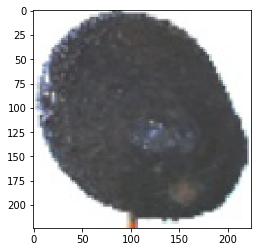

In [ ]:
for img in training_dataset:
  plt.imshow(img)
  break
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.callbacks import EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0.00000005)
callback = EarlyStopping(monitor='loss', patience=6)


Defining the first model for training with three different filters, to avoid information loss 32, 64 and 128. Padding is 2,2 (shift of 2 pixels at time). 

In [ ]:
model = ConvAutoEncoder(input_shape=(224, 224,3),
            output_dim=224, filters=[32,64,128], optimizer = Adam(10e-6))

Fitting the model (possible thanks to the Sequential class) on a small batch size and an increased number of epochs (firstly 50, then 60). 

In [ ]:
#model.ae.get_weights()
history= model.fit(training_dataset, epochs=50, batch_size =16, verbose = 1, validation_split = 0.3, callbacks = [callback, reduce_lr])


Epoch 1/50
98/98 [==============================] - 11s 107ms/step - loss: 0.1736 - accuracy: 0.4611 - val_loss: 0.1718 - val_accuracy: 0.5955
Epoch 2/50
98/98 [==============================] - 10s 107ms/step - loss: 0.1715 - accuracy: 0.5848 - val_loss: 0.1716 - val_accuracy: 0.6126
Epoch 3/50
98/98 [==============================] - 9s 97ms/step - loss: 0.1704 - accuracy: 0.6036 - val_loss: 0.1709 - val_accuracy: 0.6081
Epoch 4/50
98/98 [==============================] - 9s 97ms/step - loss: 0.1708 - accuracy: 0.6034 - val_loss: 0.1665 - val_accuracy: 0.6617
Epoch 5/50
98/98 [==============================] - 10s 97ms/step - loss: 0.1681 - accuracy: 0.6451 - val_loss: 0.1655 - val_accuracy: 0.6603
Epoch 6/50
98/98 [==============================] - 10s 98ms/step - loss: 0.1656 - accuracy: 0.6413 - val_loss: 0.1651 - val_accuracy: 0.6623
Epoch 7/50
98/98 [==============================] - 9s 97ms/step - loss: 0.1676 - accuracy: 0.6430 - val_loss: 0.1647 - val_accuracy: 0.6643
Epoch 8

Plotting model performance according to training and validation loss 

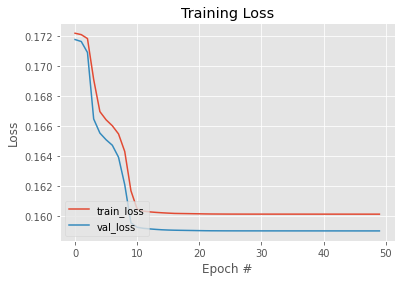

In [ ]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

plot_training(history, data_path)

Saving model weights for further training 

In [ ]:
model.save_weights()


Creating a new model to be trained with the same parameters for the model class, but different training parameters. 

In [ ]:
new_model = ConvAutoEncoder(input_shape=(224, 224,3),
            output_dim=224, filters=[32,64,128], optimizer = Adam(10e-3))
new_model.encoder.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_17 (ModuleWra (None, 224, 224, 3)       0         
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 112, 112, 32)      896       
_________________________________________________________________
module_wrapper_19 (ModuleWra (None, 56, 56, 32)        0         
_________________________________________________________________
module_wrapper_20 (ModuleWra (None, 56, 56, 32)        0         
_________________________________________________________________
module_wrapper_21 (ModuleWra (None, 28, 28, 64)        18496     
_________________________________________________________________
module_wrapper_22 (ModuleWra (None, 14, 14, 64)        0         
_________________________________________________________________
module_wrapper_23 (ModuleWra (None, 7, 7, 128)        

Creating some noise in the dataset for the model to have some troubles in learning good and representative features. 

In [ ]:
noise_factor = 0.4
training_dataset_noisy = training_dataset + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=training_dataset.shape) 
training_dataset_noisy = np.clip(training_dataset_noisy, 0., 1.)

We append the pre-saved weigths to the newly created layers. Training will be performed over a higher starting learning rate, less epochs and larger batch size. 

In [ ]:
for l1,l2 in zip(model.ae.layers,new_model.ae.layers):
    l1.set_weights(l2.get_weights())

In [ ]:
for layer in new_model.ae.layers:
    layer.trainable = True
classify_train = new_model.fit(training_dataset, epochs=20, batch_size = 32, verbose = 1, validation_split = 0.2, callbacks = [reduce_lr, callback])

Epoch 1/20
56/56 [==============================] - 51s 184ms/step - loss: 0.1685 - accuracy: 0.5668 - val_loss: 0.1648 - val_accuracy: 0.6423
Epoch 2/20
56/56 [==============================] - 9s 157ms/step - loss: 0.1638 - accuracy: 0.6605 - val_loss: 0.1582 - val_accuracy: 0.6842
Epoch 3/20
56/56 [==============================] - 9s 159ms/step - loss: 0.1578 - accuracy: 0.6675 - val_loss: 0.1577 - val_accuracy: 0.6649
Epoch 4/20
56/56 [==============================] - 9s 158ms/step - loss: 0.1613 - accuracy: 0.6479 - val_loss: 0.1569 - val_accuracy: 0.6042
Epoch 5/20
56/56 [==============================] - 9s 158ms/step - loss: 0.1583 - accuracy: 0.5970 - val_loss: 0.1566 - val_accuracy: 0.6088
Epoch 6/20
56/56 [==============================] - 9s 158ms/step - loss: 0.1592 - accuracy: 0.5994 - val_loss: 0.1566 - val_accuracy: 0.6153
Epoch 7/20
56/56 [==============================] - 9s 163ms/step - loss: 0.1608 - accuracy: 0.6035 - val_loss: 0.1566 - val_accuracy: 0.6312
Epoch

Printing model performance again 

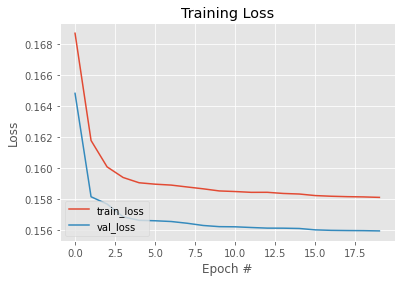

In [ ]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

plot_training(classify_train, data_path)

In [ ]:
print(len(model.encoder.layers))

7


In [ ]:
model.ae.get_weights()[0][1]

array([[[ 6.30194396e-02,  1.76427066e-02,  4.57160473e-02,
          6.29471242e-02,  1.47593915e-02, -9.09895897e-02,
         -2.75337622e-02, -2.04007328e-03, -7.53620267e-03,
         -1.07533246e-01,  5.56050539e-02, -2.85499617e-02,
         -1.00703344e-01, -6.19218349e-02,  1.03288814e-01,
         -2.95252278e-02,  3.34910303e-02, -4.16921750e-02,
         -5.64215556e-02, -1.09419845e-01,  9.23393816e-02,
         -1.16282098e-01, -2.84215361e-02,  5.31321168e-02,
         -1.07581846e-01,  6.72393292e-02, -6.85965568e-02,
         -4.41528335e-02,  8.36816132e-02, -7.94576406e-02,
          6.74999654e-02, -6.84412792e-02],
        [-6.52499646e-02,  1.19001254e-01,  3.53690386e-02,
         -3.85740399e-02, -1.18946865e-01, -1.26697809e-01,
         -3.97992879e-02, -7.51912594e-05,  1.24575153e-01,
         -6.20059744e-02, -9.51068103e-02,  1.37997404e-01,
          1.09894633e-01, -1.91923007e-02,  1.03132904e-01,
         -1.20233446e-01, -5.68796545e-02, -1.18082158e-

In [ ]:
full_model.get_weights()[0][1]

array([[[ 0.12234294, -0.07500463,  0.13429286,  0.10885696,
          0.06539884,  0.03363825,  0.13666034,  0.00521084,
         -0.08044463, -0.02213892, -0.10391934, -0.05381845,
          0.00594034,  0.08495408, -0.08077893,  0.06381074,
         -0.05897554, -0.0695977 , -0.01628928,  0.03257927,
          0.13678156,  0.03411769,  0.10291231, -0.09857502,
         -0.10292147,  0.02288858, -0.13051368, -0.0315546 ,
          0.06965494,  0.01896513, -0.05704151,  0.10424858],
        [ 0.04359286, -0.11186472,  0.05767493,  0.01363475,
         -0.11545887,  0.03412541, -0.07736792,  0.10976314,
         -0.07838079,  0.12215045,  0.06719729,  0.03453414,
          0.08481283, -0.09322656, -0.04196858,  0.13352443,
         -0.10867505,  0.05096602,  0.0901924 , -0.03141071,
         -0.04223055,  0.05279013,  0.05486338,  0.08827671,
         -0.01132474,  0.03654436,  0.04596699,  0.04449021,
          0.11390833,  0.11839234,  0.12514707,  0.08919062],
        [ 0.02576868, 

In [ ]:
print(training_dataset.shape)

(2233, 224, 224, 3)


In [ ]:
print(test_dataset.shape)

(112, 224, 224, 3)


Setting a new optimizer starting rate, commenting in order to avoid weight overloading and consequent overfitting. 

In [ ]:
new_model = ConvAutoEncoder(input_shape=(224,224,3),
            output_dim=224, filters=[32,64,128], optimizer = Adam(10e-2))
new_model.ae.summary()

#for l1,l2 in zip(new_model.ae.layers,model.ae.layers):
#    l1.set_weights(l2.get_weights())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 23,153,827
Trainable params: 23,153,827
Non-trainable params: 0
_________________________________________________________________


adding some different noise 

In [ ]:
noise_factor = 0.2
training_dataset_noisy = training_dataset+ noise_factor * np.random.normal(loc=0.0, scale=1.0, size=training_dataset.shape) 
training_dataset_noisy = np.clip(training_dataset_noisy, 0., 1.)


saving and loading weights 

In [ ]:
for l1,l2 in zip(model.ae.layers,new_model.ae.layers):
    l2.set_weights(l1.get_weights())

Shorter training on fewer epochs to avoid overfitting. 

In [ ]:
for layer in new_model.ae.layers:
    layer.trainable = True
classify_train = new_model.fit(training_dataset_noisy, epochs=10, batch_size = 32, verbose = 1, validation_split = 0.2, callbacks=[callback, reduce_lr], shuffle = True)



Epoch 1/10
28/28 [==============================] - 12s 354ms/step - loss: 0.3366 - accuracy: 0.4566 - val_loss: 0.3604 - val_accuracy: 0.4885
Epoch 2/10
28/28 [==============================] - 9s 310ms/step - loss: 0.3625 - accuracy: 0.4730 - val_loss: 0.3604 - val_accuracy: 0.4885
Epoch 3/10
28/28 [==============================] - 8s 294ms/step - loss: 0.3631 - accuracy: 0.4795 - val_loss: 0.3604 - val_accuracy: 0.4885
Epoch 4/10
28/28 [==============================] - 8s 298ms/step - loss: 0.3637 - accuracy: 0.4785 - val_loss: 0.3604 - val_accuracy: 0.4885


In [ ]:
new_model.save_weights()

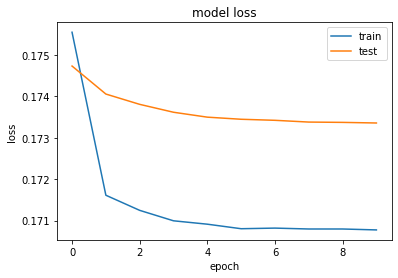

In [ ]:
plt.plot(classify_train.history['loss'])
plt.plot(classify_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Predictions are based on the pre-trained model encoder. We dropped the decoder since its main use was to understand to what extent the model had learned to reconstruct the picture. Features are then normalised for a better comparison through the norm of vectors below. 

In [ ]:
def predictions(path):
  """
    Making predictions for the query images and returns N similar images from the dataset.
    We can either pass filename or the url for the image.
    Arguments:
    label - (string) - file name of the query image.
    N - (int) - Number of images to be returned
    isurl - (string) - if query image is from google is set to True else False(By default = False)
  """
  features = []
  for img in path :
    original = load_img(img, target_size=(224,224))
    numpy_image = img_to_array(original)
    image = np.expand_dims(numpy_image, axis=0)
    x = preprocess_input(image)
    # Extract Features
    feature = new_model.encode(x)[0]
    normalized = feature / np.linalg.norm(feature)
    features.append(normalized)
  return features

Predicting features on query and gallery images

In [ ]:
features_query = predictions(query_paths)
features_gallery = predictions(gallery_paths)



In [ ]:
from pprint import pprint

Image matching through the norm of vectors for query and gallery features. Then, these are sorted in ascending order and the top 10 are returned.

In [ ]:
def match_img(query_img_feat):
  distance = np.linalg.norm(features_gallery - query_img_feat, axis=1) #vectorial distance
  acc = np.argsort(distance)[:10]  #top 5 results
  scores = [(distance[a], str(gallery_paths[a])) for a in acc]#rank the results
  scores.sort(key = lambda x:x, reverse = True) 
  return (acc, scores)

results = {}
for img in query_paths : 
  #results[img] = []
  results[os.path.basename(img)] = []
for i, feat in enumerate(features_query) : 
  acc , scores = match_img(feat)
  #results[query_paths[i]].extend([sc[1] for sc in scores])
  results[os.path.basename(query_paths[i])].extend([os.path.basename(sc[1]) for sc in scores])
pprint(results)


NameError: ignored

In [ ]:
import requests
import json


url = "http://ec2-18-191-24-254.us-east-2.compute.amazonaws.com/competition/"


In [ ]:
mydata = dict()
mydata['groupname'] = "lesdesesperadas"


res = results
mydata["images"] = res
pprint(mydata)

In [ ]:
def submit(results, url):
    res = json.dumps(results)
    response = requests.post(url, res)
    result = json.loads(response.text)
    print(f"accuracy is {result['results']}")

submit(mydata, url)

In [ ]:
import glob

In [ ]:
import sys 
from google.colab import drive 
import glob

path = "/content/drive" 
drive.mount(path, force_remount=True)  
data_path = "drive/MyDrive/Challenge(1)/dataset"


myfiles = glob.glob(os.path.join(data_path, '*')) 
print(myfiles)

Mounted at /content/drive
['drive/MyDrive/Challenge(1)/dataset/stl10.zip', 'drive/MyDrive/Challenge(1)/dataset/validation', 'drive/MyDrive/Challenge(1)/dataset/training', 'drive/MyDrive/Challenge(1)/dataset/\\second_output.csv', 'drive/MyDrive/Challenge(1)/dataset/stl10.zip (Unzipped Files)', 'drive/MyDrive/Challenge(1)/dataset/siamese_checkpoints', 'drive/MyDrive/Challenge(1)/dataset/variables', 'drive/MyDrive/Challenge(1)/dataset/assets', 'drive/MyDrive/Challenge(1)/dataset/saved_model.pb', 'drive/MyDrive/Challenge(1)/dataset/keras_metadata.pb', 'drive/MyDrive/Challenge(1)/dataset/conv_checkpoints', 'drive/MyDrive/Challenge(1)/dataset/encoder_weights.h5', 'drive/MyDrive/Challenge(1)/dataset/decoder_weights.h5', 'drive/MyDrive/Challenge(1)/dataset/new_dataset_pokemon_animals_clothes', 'drive/MyDrive/Challenge(1)/dataset/conv1_checkpoints', 'drive/MyDrive/Challenge(1)/dataset/test']


In [ ]:
test_path= os.path.join(data_path, "test")

gallery_path = os.path.join(test_path, 'gallery')
query_path = os.path.join(test_path, 'query')


# Loading the images without a class
def imag_load(path) : 
  temp_images = os.listdir(path)
  lista = []
  for i in temp_images:
    img_tmp = os.path.join(path, i)
    lista.append(img_tmp)
  return lista

gallery = imag_load(gallery_path)
query = imag_load(query_path)

# Converting to a normalized tensor of features both query and gallery
query_dataset = convert_to_array(query)
gallery_dataset = convert_to_array(gallery)

100%|██████████| 408/408 [05:33<00:00,  1.22it/s]


In [ ]:
features_query = predictions(query)
features_gallery = predictions(gallery)

In [ ]:
from pprint import pprint

In [ ]:
def match_img(features_query):
  distance = np.linalg.norm(features_gallery - features_query, axis=1) #vectorial distance
  acc = np.argsort(distance)[:10]  #top n5 results
  scores = [(distance[a], str(gallery[a])) for a in acc]#rank the results
  scores.sort(key = lambda x:x, reverse = True) 
  return (acc, scores)

results = {}
for img in query : 
  #results[img] = []
  results[os.path.basename(img)] = []
for i, feat in enumerate(features_query) : 
  acc , scores = match_img(feat)
  #results[query_paths[i]].extend([sc[1] for sc in scores])
  results[os.path.basename(query[i])].extend([os.path.basename(sc[1]) for sc in scores])
pprint(results)

{'3fpri33.jpg': ['yp9lv9j.jpg',
                 'qsfj1ta.jpg',
                 'iac9fuq.jpg',
                 '79tgriv.jpg',
                 'tvggg4f.jpg',
                 'cftkf1t.jpg',
                 'p49x44a.jpg',
                 '2p4ag1j.jpg',
                 'mr74wyh.jpg',
                 '90e01s6.jpg'],
 '4uufzmh.jpg': ['50c6lzi.jpg',
                 'u5syuyf.jpg',
                 '93va364.jpg',
                 'f3160u0.jpg',
                 'nomdbvc.jpg',
                 'ti7d1jn.jpg',
                 'iqxl9b0.jpg',
                 '1qog9al.jpg',
                 'avse4s3.jpg',
                 '14uoy8b.jpg'],
 '5qcsiay.jpg': ['sjwh4lf.jpg',
                 'szwz6h0.jpg',
                 'y2lje4u.jpg',
                 'zajtesc.jpg',
                 '4pacixk.jpg',
                 'ti7d1jn.jpg',
                 'ehevs8e.jpg',
                 '1qog9al.jpg',
                 'u5syuyf.jpg',
                 'xer1uu0.jpg'],
 '8d6bnrk.jpg': ['2p4ag1j.jpg',
     

In [ ]:
import requests
import json


url = "http://ec2-18-191-24-254.us-east-2.compute.amazonaws.com/competition/"

In [ ]:
def submit(results, url):
    res = json.dumps(results)
    response = requests.post(url, res)
    result = json.loads(response.text)
    print(f"accuracy is {result['results']}")
mydata = dict()
mydata['groupname'] = "lesdesesperadas"


res = results
mydata["images"] = res
submit(mydata, url)

accuracy is {'top1': 0.0, 'top3': 0.0, 'top10': 0.2}
